In [1]:
import os, sys
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
fp = Path("weather_forecast_data.csv")
print("File exists:", fp.exists(), "size:", fp.stat().st_size if fp.exists() else None)

df = pd.read_csv(fp)
print("Loaded dataframe with shape:", df.shape)
df.head(10)

File exists: True size: 251223
Loaded dataframe with shape: (2500, 6)


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain
5,26.147353,48.217260,15.258547,59.766279,1049.738751,no rain
6,20.939680,40.799444,2.232566,45.827508,1014.173766,no rain
7,32.294325,51.848471,2.873621,92.551497,1006.041733,no rain
8,34.091569,48.057114,5.570206,82.524873,993.732047,no rain
9,19.586038,82.978293,5.760537,98.014450,1036.503457,rain


In [3]:
# Full analytics pipeline on the loaded dataframe
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [4]:
# show basic info
info = {}
info['dtypes'] = df.dtypes.to_dict()
info['missing'] = df.isnull().sum().to_dict()
info['describe'] = df.describe().T

print("Column dtypes:\n", info['dtypes'])
print("\nMissing values:\n", info['missing'])
print("\nSummary statistics:\n", info['describe'].head(10))

Column dtypes:
 {'Temperature': dtype('float64'), 'Humidity': dtype('float64'), 'Wind_Speed': dtype('float64'), 'Cloud_Cover': dtype('float64'), 'Pressure': dtype('float64'), 'Rain': dtype('O')}

Missing values:
 {'Temperature': 0, 'Humidity': 0, 'Wind_Speed': 0, 'Cloud_Cover': 0, 'Pressure': 0, 'Rain': 0}

Summary statistics:
               count         mean        std         min         25%  \
Temperature  2500.0    22.581725   7.326996   10.001842   16.359398   
Humidity     2500.0    64.347094  19.954739   30.005071   47.339815   
Wind_Speed   2500.0     9.906255   5.780316    0.009819    4.761909   
Cloud_Cover  2500.0    49.658104  29.123104    0.015038   23.900016   
Pressure     2500.0  1014.312336  20.196433  980.014486  996.938630   

                     50%          75%          max  
Temperature    22.536448    28.976476    34.995214  
Humidity       63.920797    81.561021    99.997481  
Wind_Speed      9.908572    14.948408    19.999132  
Cloud_Cover    49.488284    75.

In [5]:
# Convert target to binary
df_clean = df.copy()
if 'Rain' in df_clean.columns:
    le = LabelEncoder()
    df_clean['Rain_bin'] = le.fit_transform(df_clean['Rain'])
    print("\nLabel classes (Rain):", list(le.classes_))
else:
    raise ValueError("No 'Rain' column found to serve as target.")



Label classes (Rain): ['no rain', 'rain']


In [6]:
# Check for non-numeric columns besides target
non_numeric = df_clean.select_dtypes(include=['object']).columns.tolist()
print("\nNon-numeric columns:", non_numeric)

# If any numeric-like objects, try to coerce
for col in non_numeric:
    if col != 'Rain':
        try:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        except:
            pass


Non-numeric columns: ['Rain']


In [7]:
 #Drop rows with missing values (report how many)
before = len(df_clean)
df_clean = df_clean.dropna()
after = len(df_clean)
print(f"\nDropped {before-after} rows with missing values. Remaining rows: {after}")

# Correlation matrix
corr = df_clean.select_dtypes(include=[np.number]).corr()
print("\nNumeric correlation:\n", corr)


Dropped 0 rows with missing values. Remaining rows: 2500

Numeric correlation:
              Temperature  Humidity  Wind_Speed  Cloud_Cover  Pressure  \
Temperature     1.000000 -0.014119   -0.004957     0.006632 -0.007489   
Humidity       -0.014119  1.000000    0.003816     0.007244 -0.032089   
Wind_Speed     -0.004957  0.003816    1.000000    -0.000405  0.018772   
Cloud_Cover     0.006632  0.007244   -0.000405     1.000000  0.023100   
Pressure       -0.007489 -0.032089    0.018772     0.023100  1.000000   
Rain_bin       -0.265882  0.382464   -0.001389     0.326216  0.008273   

             Rain_bin  
Temperature -0.265882  
Humidity     0.382464  
Wind_Speed  -0.001389  
Cloud_Cover  0.326216  
Pressure     0.008273  
Rain_bin     1.000000  


In [8]:

# Show top 10 rows to user
try:
    from ace_tools import display_dataframe_to
    display_dataframe_to("Sample of cleaned data", df_clean.head(50))
except Exception:
    # fallback: print head
    print("\nSample of cleaned data:\n", df_clean.head(10))



Sample of cleaned data:
    Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain  \
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain   
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain   
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain   
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain   
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain   
5    26.147353  48.217260   15.258547    59.766279  1049.738751  no rain   
6    20.939680  40.799444    2.232566    45.827508  1014.173766  no rain   
7    32.294325  51.848471    2.873621    92.551497  1006.041733  no rain   
8    34.091569  48.057114    5.570206    82.524873   993.732047  no rain   
9    19.586038  82.978293    5.760537    98.014450  1036.503457     rain   

   Rain_bin  
0         1  
1         0  
2         0  
3         1  
4         0  
5         0  
6         0  
7         0  
8         0

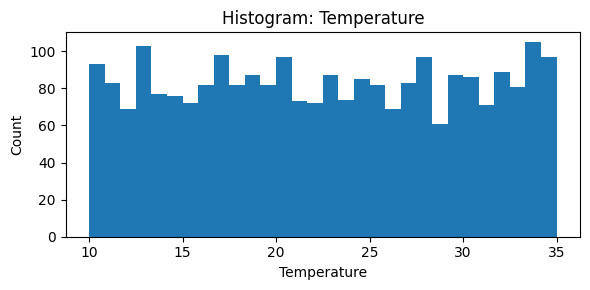

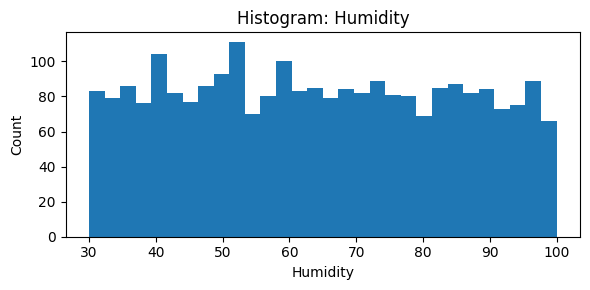

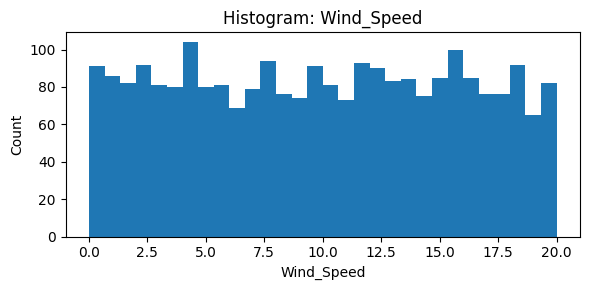

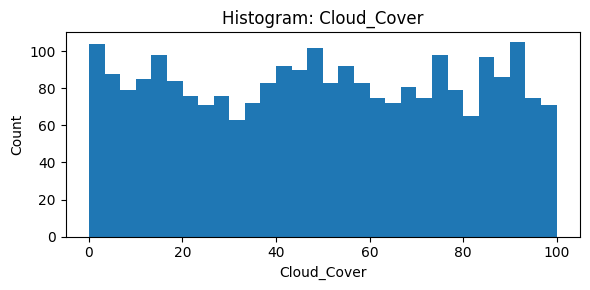

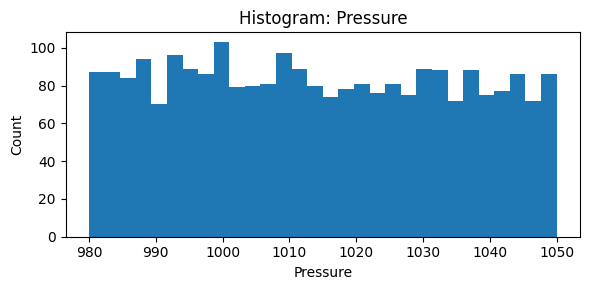

In [9]:

# Plots: histograms for numeric columns
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# exclude target
if 'Rain_bin' in num_cols:
    num_cols_non_target = [c for c in num_cols if c != 'Rain_bin']
else:
    num_cols_non_target = num_cols

for col in num_cols_non_target:
    plt.figure(figsize=(6,3))
    plt.hist(df_clean[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()





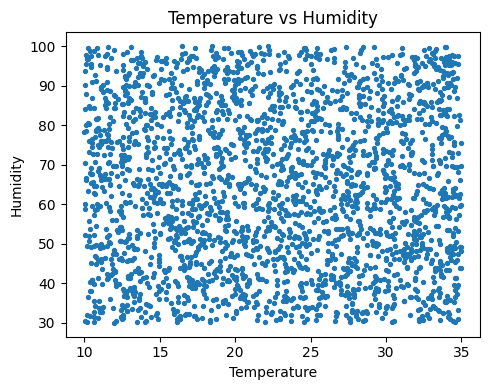

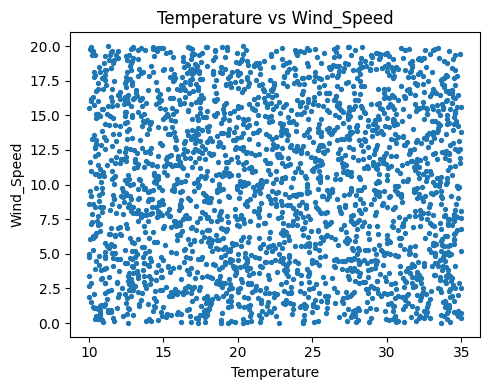

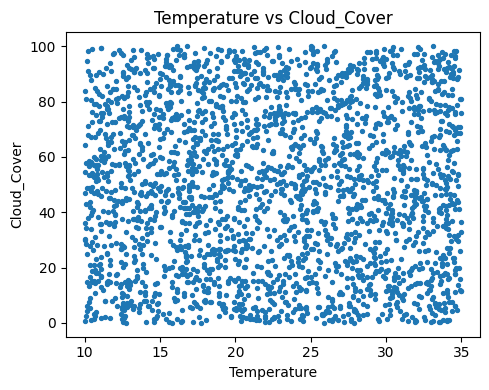

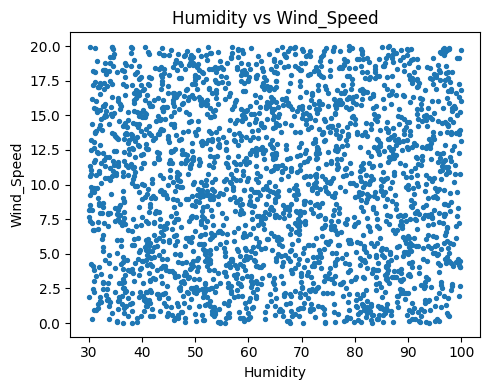

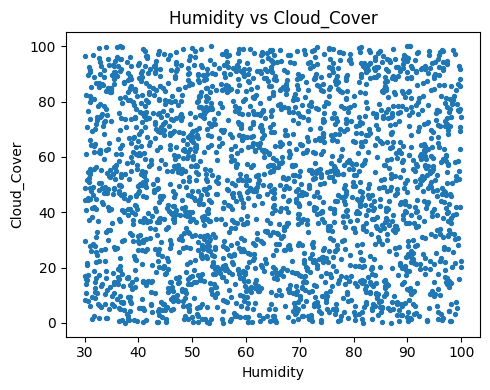

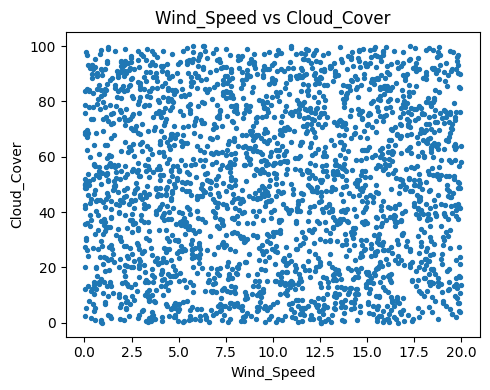

In [10]:
# Scatter matrix-ish: pairwise scatter for first 4 numeric features
pairs = num_cols_non_target[:4]
if len(pairs) >= 2:
    for i in range(len(pairs)):
        for j in range(i+1, len(pairs)):
            plt.figure(figsize=(5,4))
            plt.scatter(df_clean[pairs[i]], df_clean[pairs[j]], s=8)
            plt.xlabel(pairs[i])
            plt.ylabel(pairs[j])
            plt.title(f"{pairs[i]} vs {pairs[j]}")
            plt.tight_layout()
            plt.show()

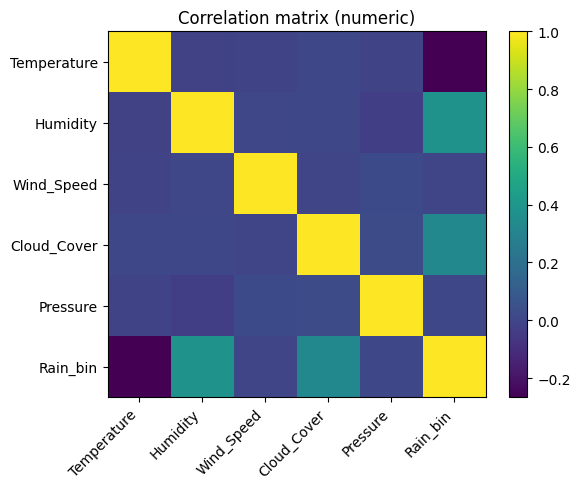

In [11]:
# Correlation heatmap using imshow
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation matrix (numeric)")
plt.tight_layout()
plt.show()

In [12]:

# Modeling: predict Rain_bin
X = df_clean[num_cols_non_target]
y = df_clean['Rain_bin']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_s, y_train)
y_pred = rf.predict(X_test_s)

acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest accuracy: {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:\n", feat_imp)

# Save model and scaler
joblib.dump(rf, "/mnt/data/rf_weather_model.pkl")
joblib.dump(scaler, "/mnt/data/rf_weather_scaler.pkl")
print("\nSaved model to /mnt/data/rf_weather_model.pkl and scaler to /mnt/data/rf_weather_scaler.pkl")

# Save a cleaned CSV
df_clean.to_csv("/mnt/data/weather_forecast_data_cleaned.csv", index=False)
print("Saved cleaned data to /mnt/data/weather_forecast_data_cleaned.csv")


Random Forest accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

     no rain       1.00      1.00      1.00       437
        rain       1.00      1.00      1.00        63

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


Confusion matrix:
 [[437   0]
 [  0  63]]

Feature importances:
 Humidity       0.376693
Cloud_Cover    0.329689
Temperature    0.265187
Pressure       0.017021
Wind_Speed     0.011410
dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/rf_weather_model.pkl'

In [ ]:
pip install --upgrade --force-reinstall matplotlib scipy pandas scikit-learn


In [ ]:
pip install --upgrade matplotlib scipy pandas

In [ ]:
pip install --upgrade 'pybind11>=2.12'

In [ ]:
pip install --no-binary :all: matplotlib